In [4]:
!pwd

/home/ec2-user/SageMaker/data


In [5]:
import os
os.chdir('/home/ec2-user/SageMaker/')

In [1]:
import pandas as pd
import numpy as np

In [6]:
data = pd.read_csv('data/train.csv')


In [7]:
data.head()

,prompt
0,"man waking up, dark and still room, cinematic ..."
1,Yate con familia feliz navegando por el mar ca...
2,"Many friendly alien race individuals. fantasy,..."
3,"theo james as cyclops, cyberpunk futuristic ne..."
4,Portrait of a beautiful woman with long hair o...


# Dataset size

In [8]:
data.shape

(726362, 1)

In [18]:
data = data.astype('str')

# Text/ paragraph length distribution

In [12]:
data["prompt_length"] = data['prompt'].apply(len)

<Axes: ylabel='Frequency'>

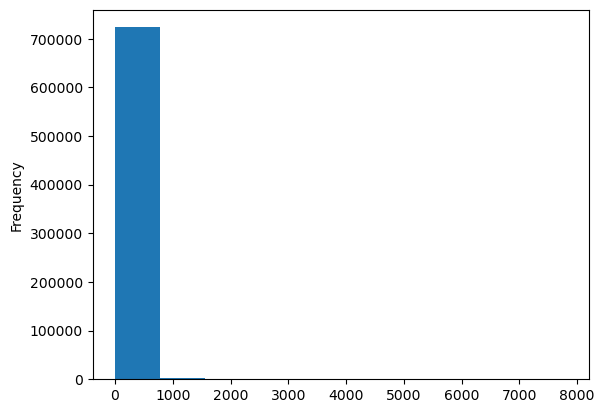

In [16]:
data["prompt_length"].plot.hist()

# Word count 

In [22]:
def word_count(text):
    # Split the text by whitespace and count the resulting list's length
    return len(text.split())

# Apply the function to the 'text' column and create a new column 'word_count'
data['word_count'] = data['prompt'].apply(word_count)

In [23]:
data["word_count"].describe()

count    726362.000000
mean         19.729982
std          21.468646
min           1.000000
25%           7.000000
50%          14.000000
75%          28.000000
max        1163.000000
Name: word_count, dtype: float64

# Analyse tokenization pattern

In [25]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
from collections import Counter
def tokenize_text(text):
    return nltk.word_tokenize(text)

# Apply tokenization to the text column
data['tokens'] = data['prompt'].apply(tokenize_text)

# Flatten the list of tokens and count frequency
all_tokens = [token for sublist in data['tokens'] for token in sublist]
token_counts = Counter(all_tokens)

# Convert to DataFrame for easy manipulation
token_df = pd.DataFrame(token_counts.items(), columns=['token', 'count'])

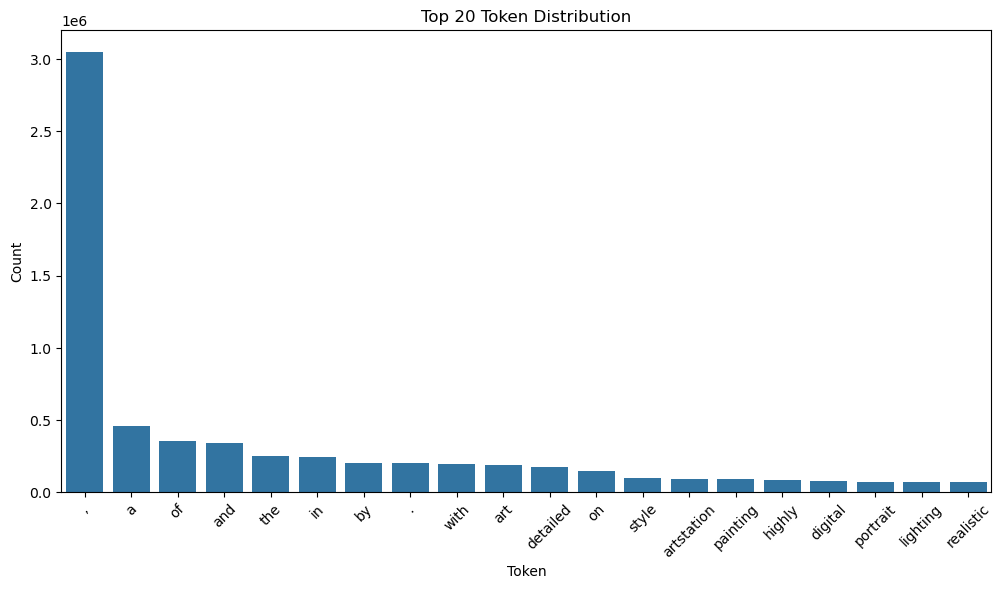

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='token', y='count', data=token_df.sort_values(by='count', ascending=False).head(20))
plt.title('Top 20 Token Distribution')
plt.xlabel('Token')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Topic modeling

In [29]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 23.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel


# Preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

# Apply preprocessing to the text column
data['processed_text'] = data['prompt'].apply(preprocess_text)

# Create a dictionary and corpus
dictionary = corpora.Dictionary(data['processed_text'])
corpus = [dictionary.doc2bow(text) for text in data['processed_text']]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=2, id2word=dictionary, passes=10)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data['processed_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')
